## 01 UNet Training

The UNet model is used to distinguish background from forground i.e. DAPI nuclei from cytosol or intracellular space. To ensure the most accurate prediction, ideally only images that are similar to the later predictions are trained on. Therefore, the data science bowl is disregarded and only home-labeled nuclei are used.

In [1]:
import glob
import skimage
import datetime
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

import utils.data_provider
import utils.dirtools
import utils.evaluation
import utils.model_builder
import utils.metrics
import utils.objectives

/Users/beichenberger/anaconda3/envs/image/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/beichenberger/anaconda3/envs/image/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/beichenberger/anaconda3/envs/image/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/beichenberger/anac

### Image import

Assumes all images are in the 'tif' file format and are grayscale. As the detection will only occur on 'normal' DAPI labelled nuclei, all images are also assumed to have black as background and white as signal. Signal density is not deterministic. As the same images are used for the stardist prediction later, each nuclei should be labeled uniquely.

In [2]:
root = '/Users/beichenberger/Downloads/Training/Stardist_training/train_val/'
img_size = 256

In [3]:
# Import paths
X = sorted(glob.glob(f'{root}images/*.tif'))
Y = sorted(glob.glob(f'{root}masks/*.tif'))

In [4]:
# Train / valid split
x_train, x_valid, y_train, y_valid = utils.dirtools.train_valid_split(x_list=X, y_list=Y, valid_split=0.2)

Total images: 753
– training images: 602
– validation images: 151


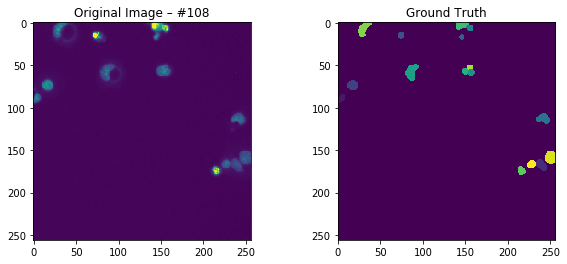

In [5]:
# Sanity check
ix = np.random.randint(0, len(X)-1)

fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].imshow(skimage.io.imread(X[ix]))
ax[0].set_title(f'Original Image – #{ix}')
ax[1].imshow(skimage.io.imread(Y[ix]))
ax[1].set_title('Ground Truth')
plt.show()

### Build model

In [6]:
# Build model
tf.keras.backend.clear_session()
model = utils.model_builder.standard_unet(img_size=256)
model.summary()

# Compile model
# loss = utils.objectives.weighted_crossentropy
loss = 'categorical_crossentropy'
metrics = [tf.keras.metrics.categorical_accuracy]
optimizer = 'adam'
model.compile(loss=loss, metrics=metrics, optimizer=optimizer)

# Callbacks
model_name = f"./models/{datetime.date.today().strftime('%Y%m%d')}_UNet"
callbacks = [utils.metrics.PlotLosses(),
             tf.keras.callbacks.ModelCheckpoint(f'{model_name}.h5', save_best_only=True),
             tf.keras.callbacks.CSVLogger(filename=f'{model_name}.csv')]

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 8)  80          input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 256, 8)  32          conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 8)  584         batch_norm

### Training

In [7]:
# Build generators
train_gen = utils.data_provider.random_sample_generator(
    x_list=x_train,
    y_list=y_train,
    batch_size=16,
    bit_depth=16,
    dim_size=img_size)

val_gen = utils.data_provider.random_sample_generator(
    x_list=x_valid,
    y_list=y_valid,
    batch_size=16,
    bit_depth=16,
    dim_size=img_size)

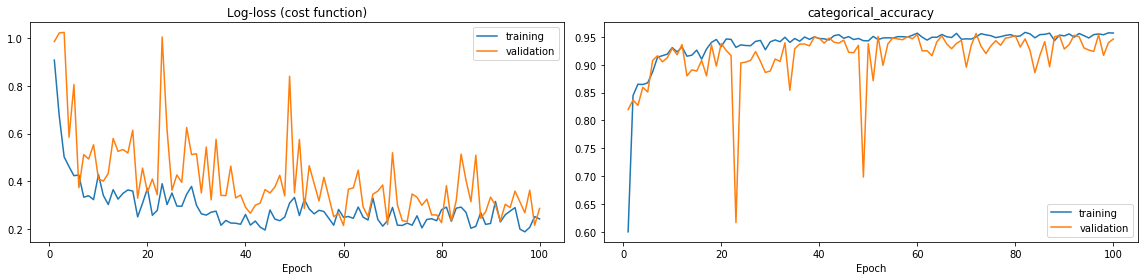

20/20 [==============================] - 114s 6s/step - loss: 0.2422 - categorical_accuracy: 0.9571 - val_loss: 0.2861 - val_categorical_accuracy: 0.9463


In [8]:
# Training
statistics = model.fit_generator(generator=train_gen,
                                 steps_per_epoch=20,
                                 epochs=100,
                                 validation_data=val_gen,
                                 validation_steps=20,
                                 callbacks=callbacks,
                                 verbose=1)

model.save_weights(f'{model_name}_final.h5)